In [1]:
from __future__ import print_function
import PIL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import csv
plt.rcParams.update({'font.size': 16})
%matplotlib inline
%config InlineBackend.figure_format='retina'

from mpl_toolkits import mplot3d
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
import os
from tqdm.notebook import tqdm
import random
import seaborn as sns

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform

from astroML import stats as astroMLstatsπ
#from astroML.linear_model import LinearRegression
from astroML.classification import GMMBayes
from astroML.utils import completeness_contamination

from scipy import stats, interpolate
from astropy.visualization import hist

from sklearn import datasets, preprocessing
from sklearn.manifold import Isomap
import sklearn.model_selection
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Galaxy or quasar with neural networks

In [2]:
import requests

if not os.path.exists("./galaxyquasar.csv"):
    
    # Download file
    r = requests.get('https://raw.githubusercontent.com/dgerosa/astrostatistics_bicocca_2023/main/solutions/galaxyquasar.csv')

else:
        data = pd.read_csv("galaxyquasar.csv", delimiter= ',')
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
u_g = np.array(data['u'] - data['g'])
g_r = np.array(data['g'] - data['r'])
r_i = np.array(data['r'] - data['i'])
i_z = np.array(data['i'] - data['z'])
z_red = np.array(data['z1'])
X = np.column_stack((u_g, g_r, r_i, i_z, z_red))
labels = ['u-g', 'g-r', 'r-i', 'i-z']

class_ = np.array(data['class'])
class_

target = np.where(class_=='QSO',1,0)
target

array([1, 0, 0, ..., 0, 0, 0])

Let's plot a cornerplot to visualize the data and to investigate which color has the most importance in detecting/differentiating galaxies and quasars\
$\longrightarrow$ u-g shows a clear bimodality!

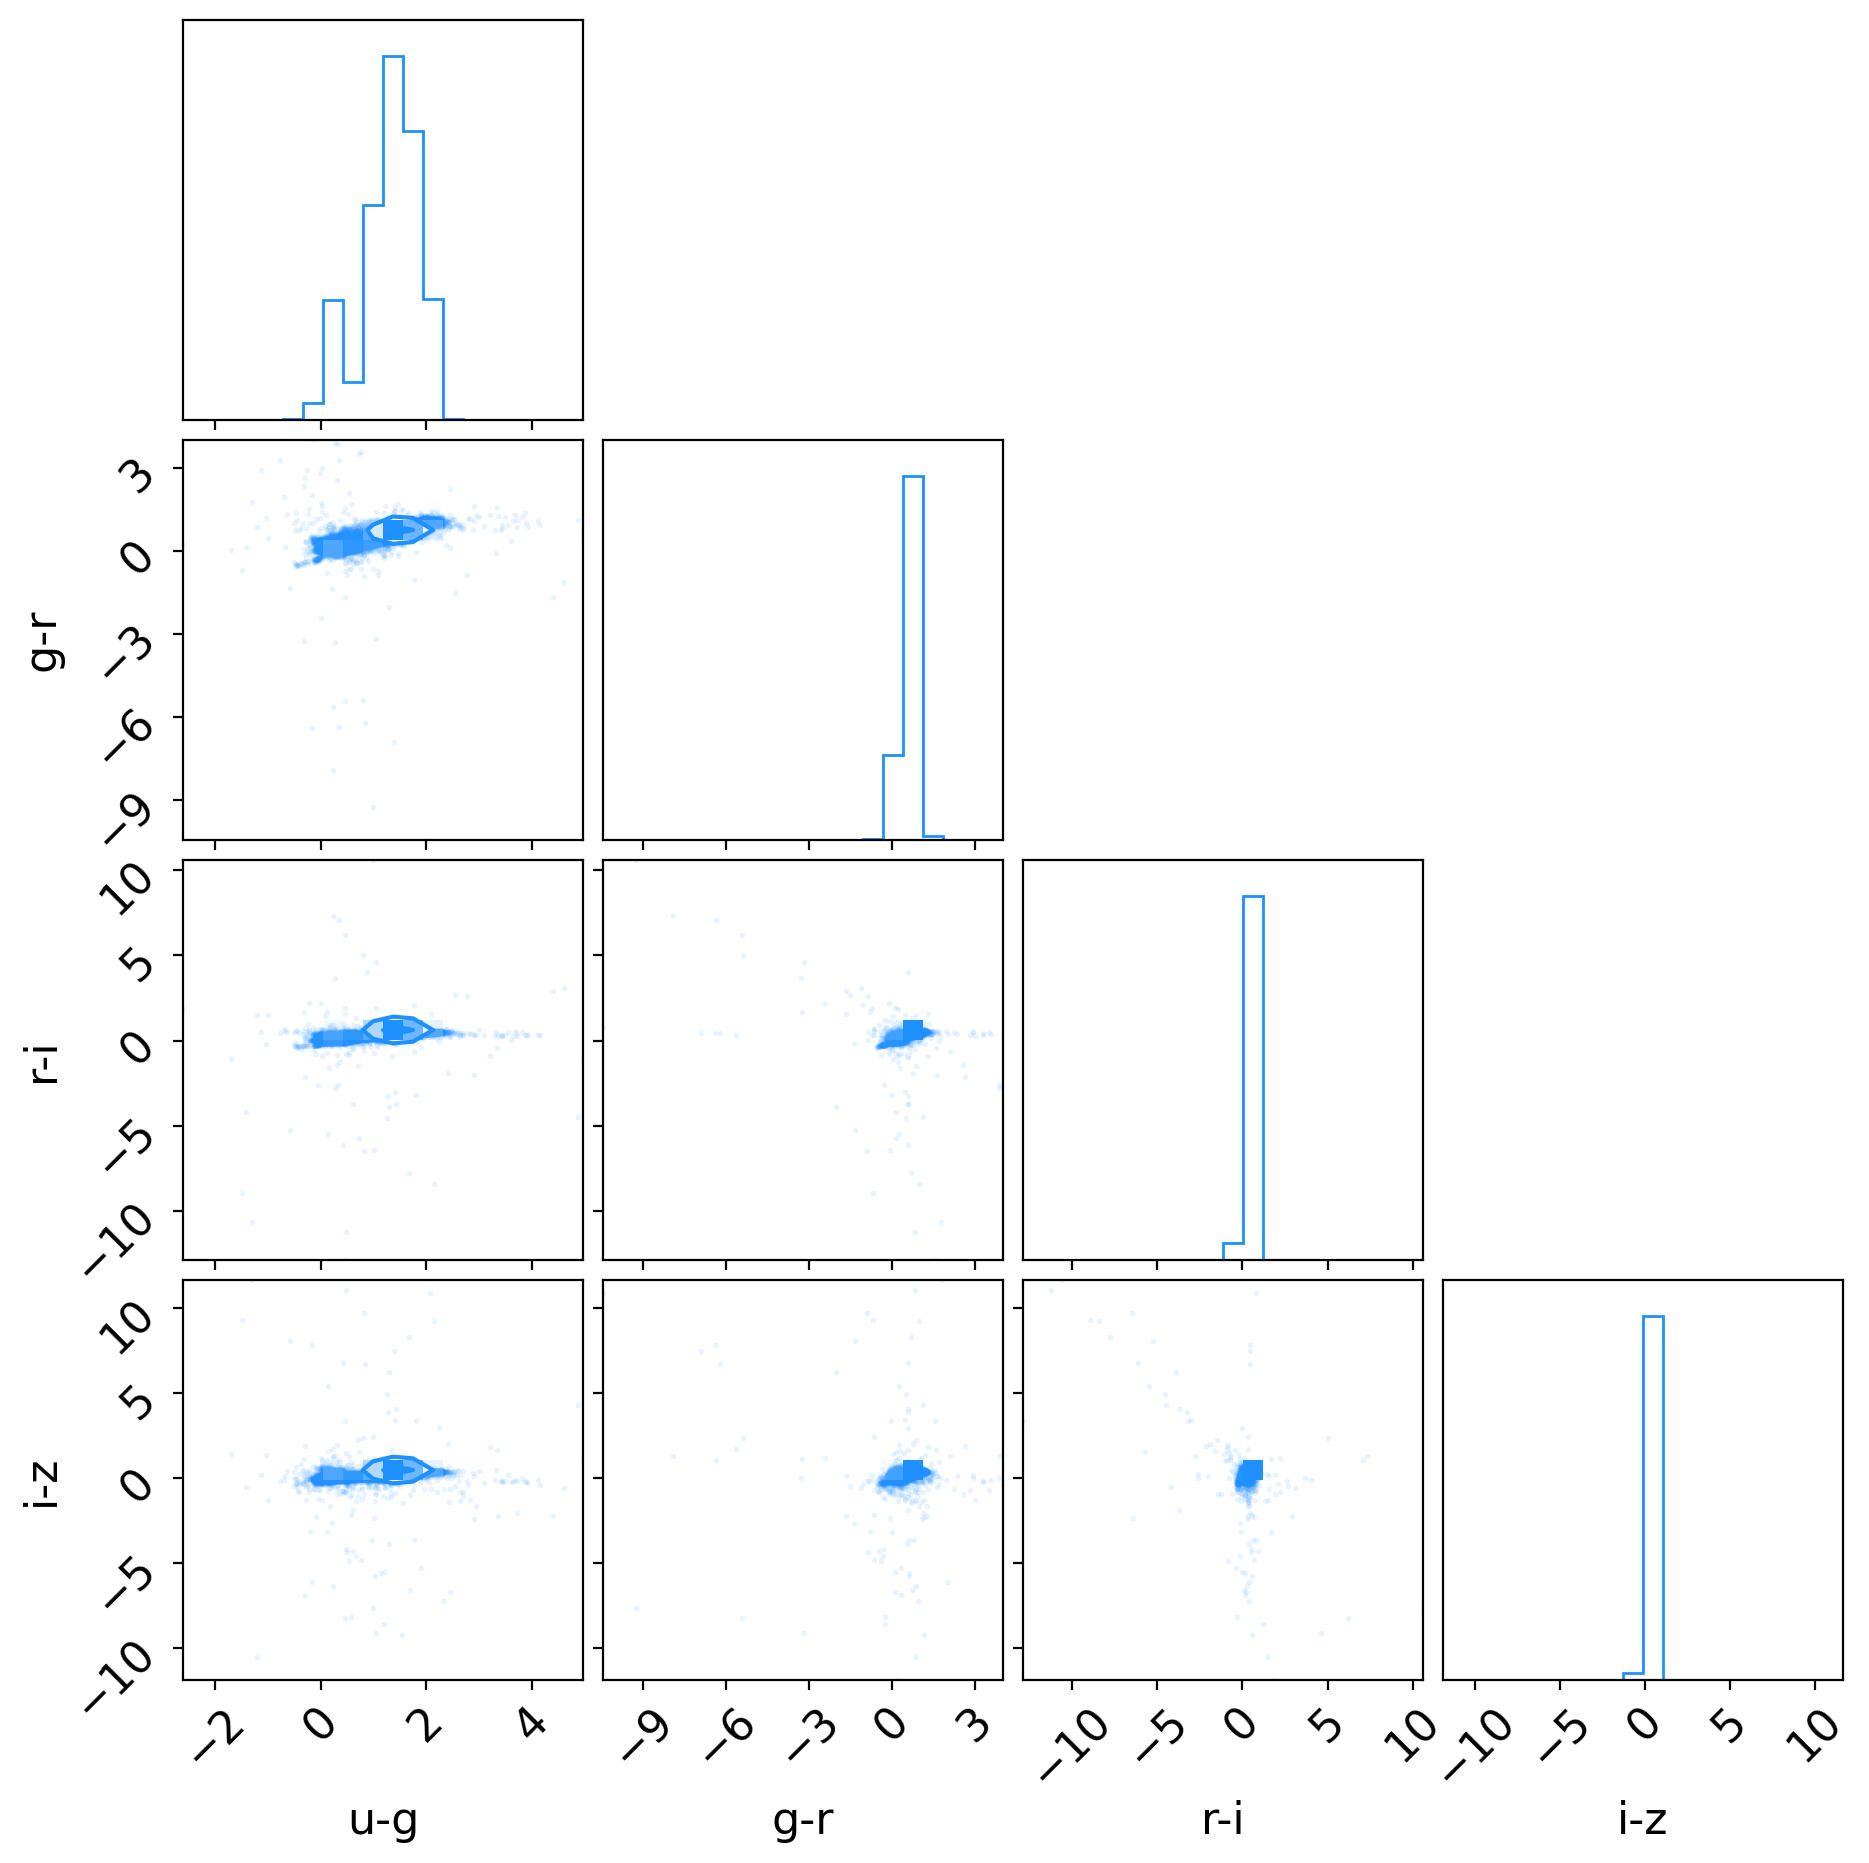

In [4]:
import corner
corner.corner(np.array([u_g,g_r,r_i,i_z]).T, labels=labels,color='dodgerblue');

## Neural network classifier

First let's try to classify the two categories with a neural network with 5 hidden layers and other non-optimized initial parametrs

------
We get a classification with a true positive rate of 98%!

In [5]:
sc = StandardScaler()
Xscale = sc.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(Xscale, target, test_size=0.3, random_state=42)
X_train.shape[0]/Xscale.shape[0]

0.7

In [7]:
clf = MLPClassifier(
    hidden_layer_sizes=(5), 
    activation='relu',
    solver='adam',
    alpha=0,
    learning_rate_init=0.001,
    max_iter=500)

In [8]:
%timeit clf.fit(X_train, y_train)
print([coef.shape for coef in clf.coefs_])  # print the weights 
y_prob=clf.predict_proba(X_test)[:,1]

2.34 s ± 842 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
[(5, 5), (5, 1)]


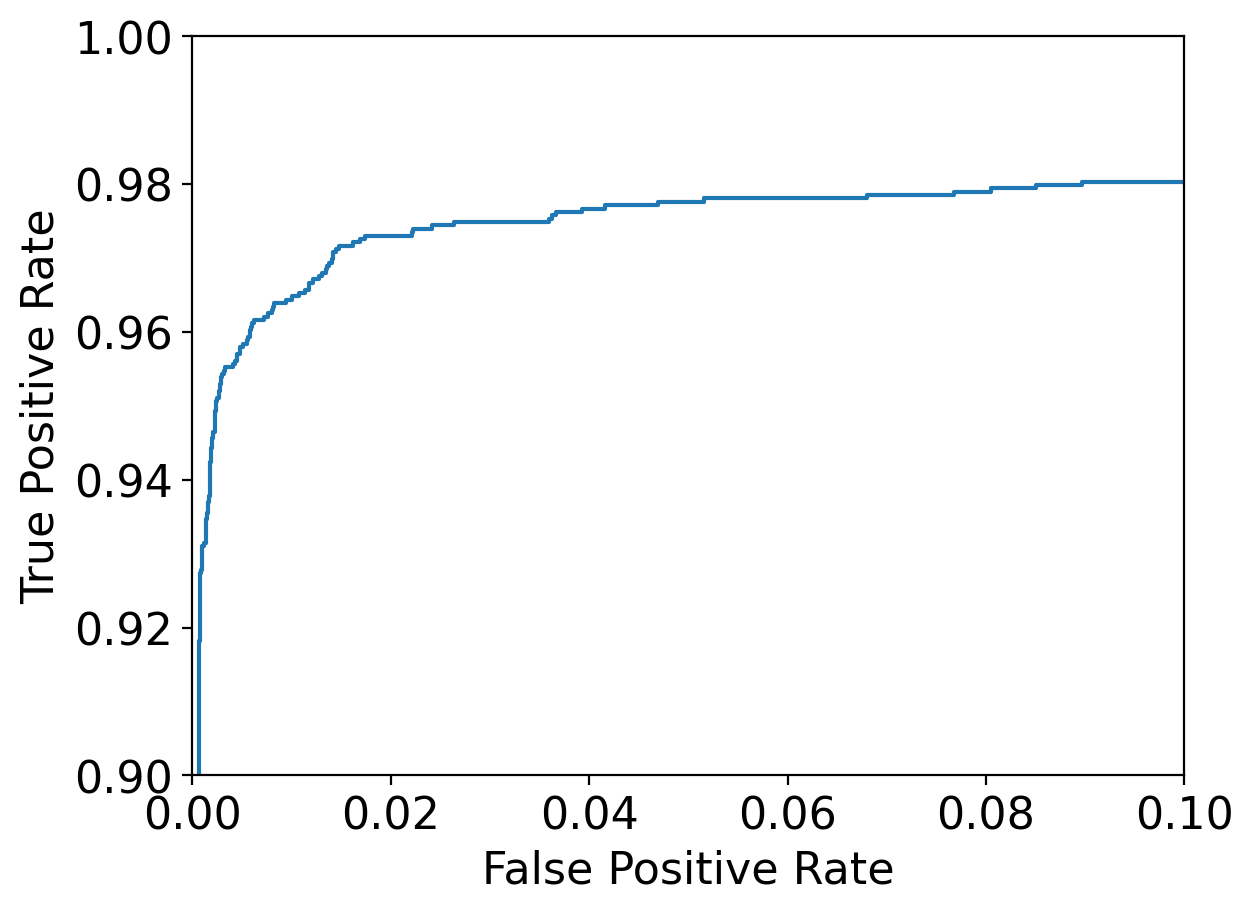

In [9]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

Now we want to optimize all the free parameters of the chosen neural network: number of layers, activation function, alpha, learning rate....

------
We have improved our TPR of 1%!

In [10]:
parameter_space = {
    'hidden_layer_sizes': [(5,),(10,), (5,5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.002, 0.05],
    'learning_rate': ['constant','adaptive'],
}


gscv = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=4)

#%timeit gscv.fit(X_train[:1000], y_train[:1000]) 
%timeit gscv.fit(X_train, y_train) 

5min 19s ± 6.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
gscv.best_params_

{'activation': 'tanh',
 'alpha': 0.002,
 'hidden_layer_sizes': (5, 5),
 'learning_rate': 'constant',
 'solver': 'adam'}

In [12]:
bestclf = gscv.best_estimator_
bestclf.fit(X_train, y_train)
y_prob=bestclf.predict_proba(X_test)[:,1]

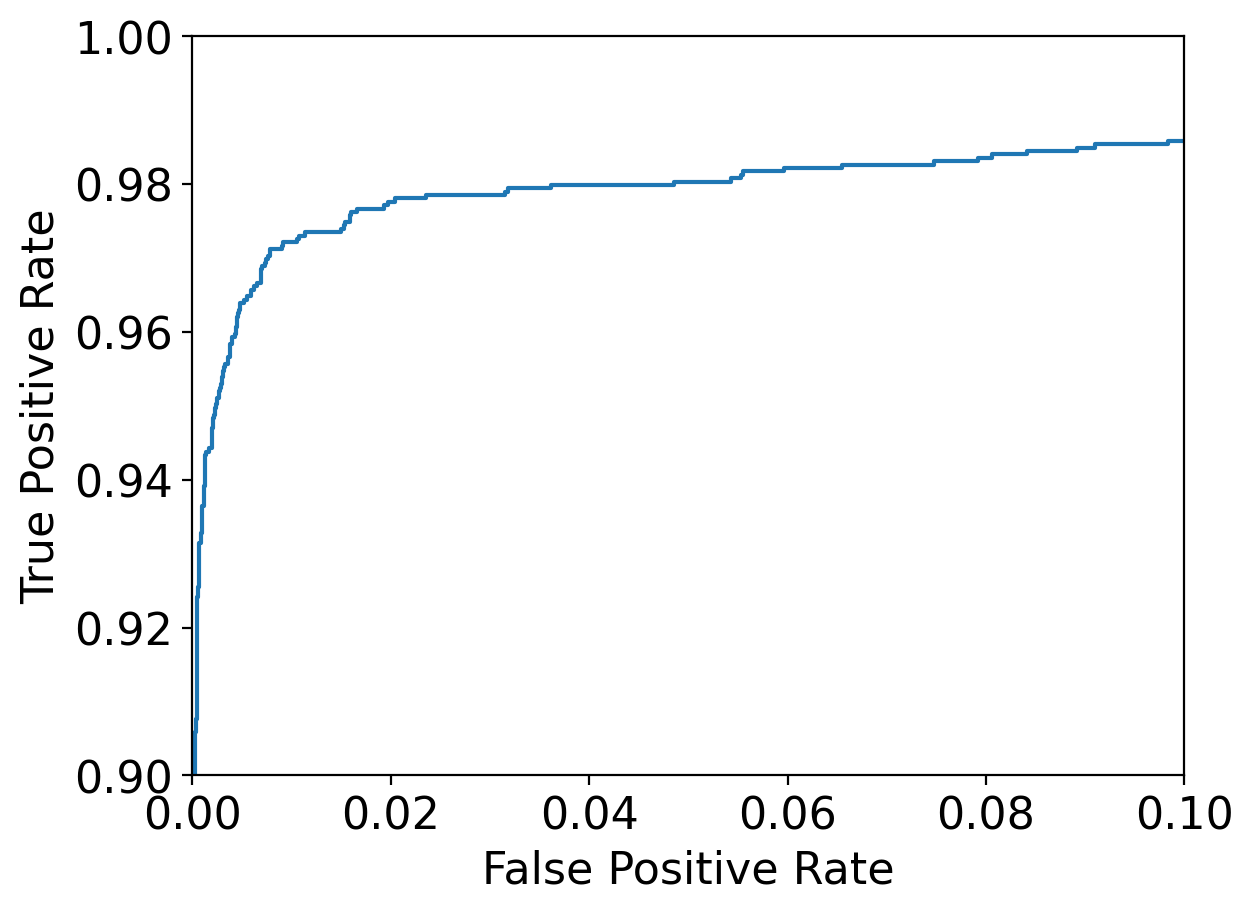

In [13]:
fpr_b, tpr_b, thresh_b = roc_curve(y_test, y_prob)
plt.plot(fpr_b, tpr_b)
plt.xlim(0,0.1)
plt.ylim(0.9,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [14]:
y_pred=bestclf.predict(Xscale)

In [15]:
d = np.column_stack((u_g, g_r, r_i, i_z, target))
target.shape
d.shape

(50000, 5)

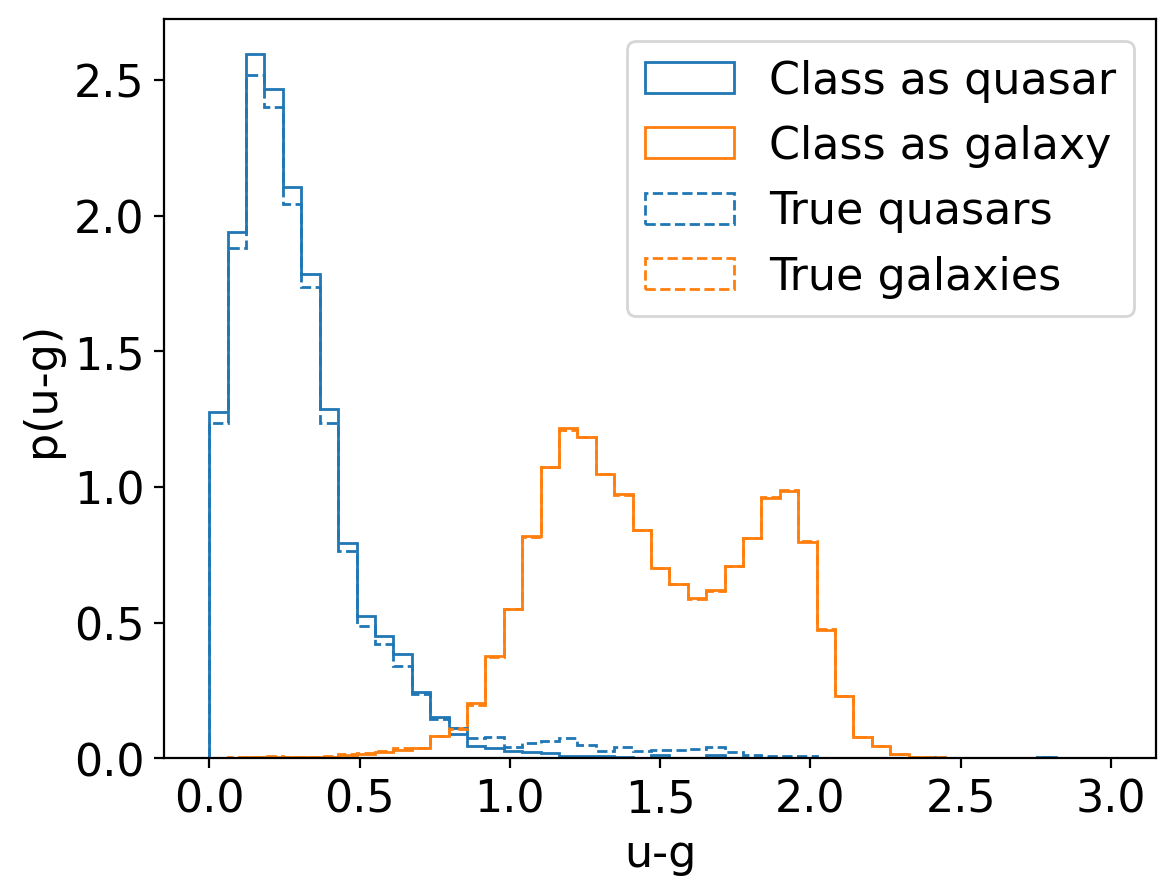

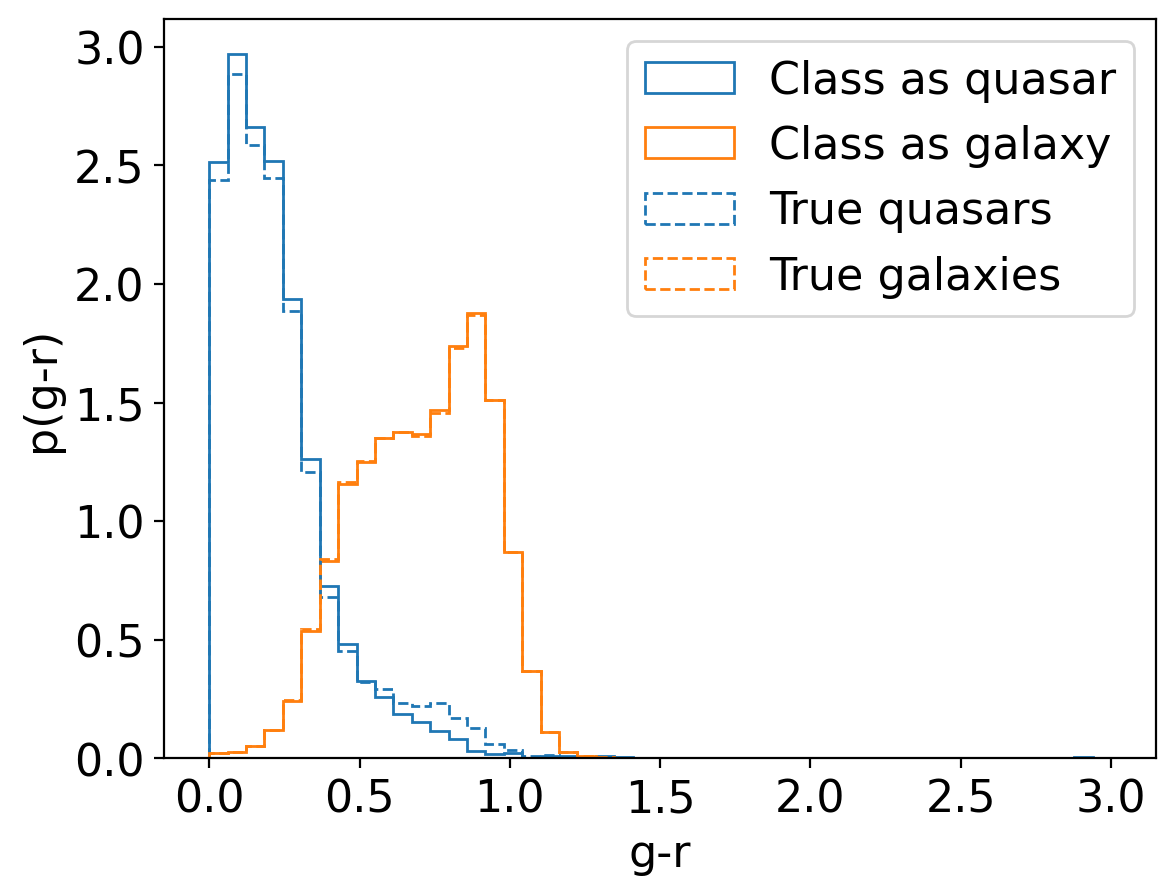

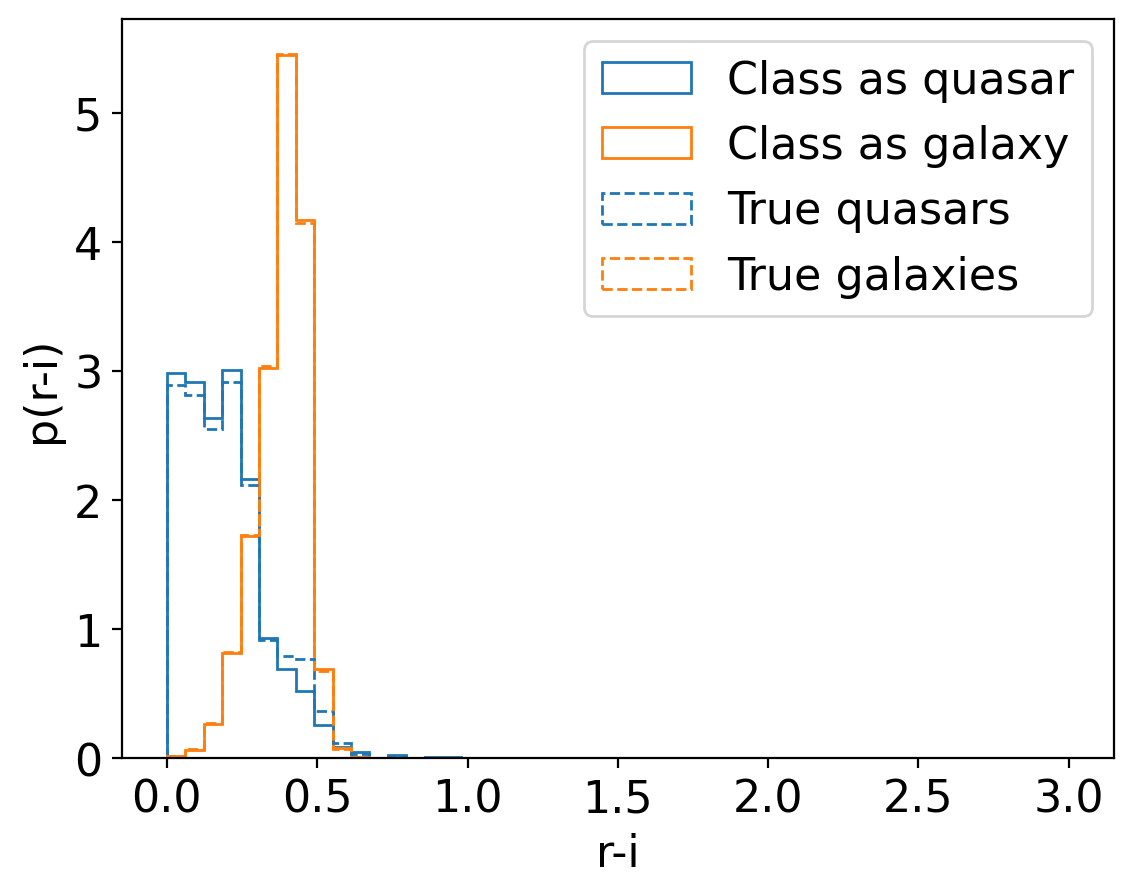

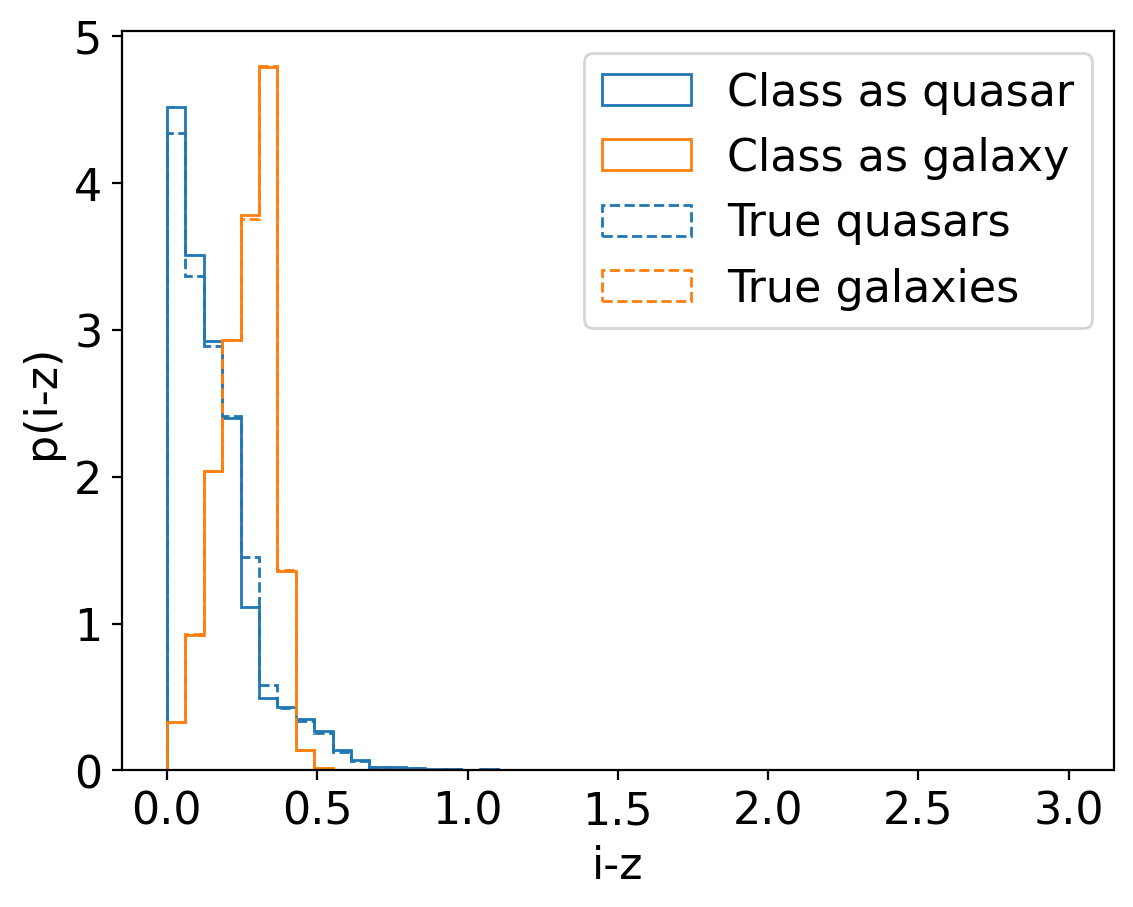

In [17]:
for i in range(len(labels)):

    plt.hist(d[y_pred==1,i],histtype='step',bins=np.linspace(0,3,50),density=True,color='C0', label='Class as quasar')
    plt.hist(d[y_pred==0,i],histtype='step',bins=np.linspace(0,3,50),density=True,color='C1', label='Class as galaxy')

    plt.hist(d[target==1,i],histtype='step',bins=np.linspace(0,3,50),density=True,color='C0',ls='dashed', label='True quasars')
    plt.hist(d[target==0,i],histtype='step',bins=np.linspace(0,3,50),density=True,color='C1',ls='dashed', label='True galaxies')
    #plt.xlim(0,3)
    plt.xlabel(labels[i])
    plt.ylabel("p("f'{labels[i]}'")")
    plt.legend()
    plt.show()